In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
!pip install plotly
!pip install folium


     |████████████████████████████████| 92kB 1.2MB/s eta 0:00:01


In [7]:
#Graphical Libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium.plugins import MarkerCluster, MiniMap, Fullscreen
import branca
from IPython.display import IFrame, YouTubeVideo

In [8]:
url_case = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_cured = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

### Create a function to transform 3 datasets

In [9]:
def load_csv(url, measure_name):
    df = pd.read_csv(url, index_col=[0, 1, 2, 3])
    df = df.stack()
    df = df.reset_index()
    
    cum = 'cum_' + measure_name
    df.columns = ['prov_state', 'country', 'lat', 'long', 'date', cum]
    
    df.date = pd.to_datetime(df.date, format='%m/%d/%y')
    
    df = df[df[cum] != 0]
    
    df['location'] = np.where(df.prov_state.isnull(), df.country, df.prov_state)
    
    new = 'new_' + measure_name
    df[new] = df.groupby('location')[cum].diff(1)
    df[new] = df[new].fillna(df[cum])
    
    return df[['location', 'prov_state', 'country', 'lat', 'long', 'date', cum, new]] # rearrange the columns and return the df

In [10]:
case = load_csv(url_case, 'case')
death = load_csv(url_death, 'death')
cured = load_csv(url_cured, 'cured')

In [11]:
case.shape

(3519, 8)

In [12]:
death.shape

(959, 8)

In [13]:
cured.shape

(1979, 8)

In [14]:
# Merge into 1 dataframe.
df = pd.merge(case, death, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])
df = pd.merge(df, cured, how='left', on=['location', 'prov_state', 'country', 'lat', 'long', 'date'])

In [15]:
#Inspect Null Values
df.isnull().sum()

location         0
prov_state    1214
country          0
lat              0
long             0
date             0
cum_case         0
new_case         0
cum_death     2560
new_death     2560
cum_cured     1540
new_cured     1540
dtype: int64

In [35]:
df.dtypes

location              object
prov_state            object
country               object
lat                  float64
long                 float64
date          datetime64[ns]
cum_case               int64
new_case             float64
cum_death            float64
new_death            float64
cum_cured            float64
new_cured            float64
dtype: object

In [21]:
df.tail(10)

location                prov_state       country  \
3509         Bergen County, NJ         Bergen County, NJ            US   
3510         Harris County, TX         Harris County, TX            US   
3511  San Francisco County, CA  San Francisco County, CA            US   
3512              South Africa                       NaN  South Africa   
3513          Clark County, NV          Clark County, NV            US   
3514      Fort Bend County, TX      Fort Bend County, TX            US   
3515          Grant County, WA          Grant County, WA            US   
3516         Queens County, NY         Queens County, NY            US   
3517     Santa Rosa County, FL     Santa Rosa County, FL            US   
3518     Williamson County, TN     Williamson County, TN            US   

          lat      long       date  cum_case  new_case  cum_death  new_death  \
3509  40.9263  -74.0770 2020-03-05         2       2.0        NaN        NaN   
3510  29.7752  -95.3103 2020-03-05         2       2.0        NaN        NaN   
3511  37.7749 -122.4194 2020-03-05         2       2.0        NaN        NaN   
3512 -30.5595   22.9375 2020-03-05         1       1.0        NaN        NaN   
3513  36.0796 -115.0940 2020-03-05         1       1.0        NaN        NaN   
3514  29.5693  -95.8143 2020-03-05         1       1.0        NaN        NaN   
3515  47.1981 -119.3732 2020-03-05         1       1.0        NaN        NaN   
3516  40.7282  -73.7949 2020-03-05         1       1.0        NaN        NaN   
3517  30.7690  -86.9824 2020-03-05         1       1.0        NaN        NaN   
3518  35.9179  -86.8622 2020-03-05         1       1.0        NaN        NaN   

      cum_cured  new_cured  
3509        NaN        NaN  
3510        NaN        NaN  
3511        NaN        NaN  
3512        NaN        NaN  
3513        NaN        NaN  
3514        NaN        NaN  
3515        NaN        NaN  
3516        NaN        NaN  
3517        NaN        NaN  
3518        NaN        NaN

In [63]:
df_last_update = df[df.date == '2020-03-05']
df_last_update.head()

location prov_state         country      lat      long       date  \
43       Anhui      Anhui  Mainland China  31.8257  117.2264 2020-03-05   
87     Beijing    Beijing  Mainland China  40.1824  116.4142 2020-03-05   
131  Chongqing  Chongqing  Mainland China  30.0572  107.8740 2020-03-05   
175     Fujian     Fujian  Mainland China  26.0789  117.9874 2020-03-05   
218      Gansu      Gansu  Mainland China  36.0611  103.8343 2020-03-05   

     cum_case  new_case  cum_death  new_death  cum_cured  new_cured  
43        990       0.0        6.0        0.0      970.0       14.0  
87        418       0.0        8.0        0.0      297.0        0.0  
131       576       0.0        6.0        0.0      512.0       10.0  
175       296       0.0        1.0        0.0      277.0        7.0  
218       102      11.0        2.0        0.0       87.0        0.0

In [65]:
#Confirmed Case worldwide
df_last_update.cum_case.sum()
print('\n Confirmed cases worldwide: ',df_last_update.cum_case.sum())
print('\n Death cases worldwide: ',df_last_update.cum_death.sum())
print('\n Recovered cases worldwide: ',df_last_update.cum_cured.sum())


 Confirmed cases worldwide:  97886

 Death cases worldwide:  3348.0

 Recovered cases worldwide:  53797.0


In [17]:
#Countries affected
countries = df.country.unique().tolist()
print(countries)

print("Numbers of countries affected by nCov:", len(countries))

['Mainland China', 'Thailand', 'Japan', 'South Korea', 'Taiwan', 'US', 'Macau', 'Hong Kong', 'Singapore', 'Vietnam', 'France', 'Nepal', 'Malaysia', 'Canada', 'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland', 'United Arab Emirates', 'Philippines', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia', 'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil', 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland', 'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Saint Barthelemy', 'Hungary', 'Faroe Islands', 'Gibraltar', 'Liechtenstein', '

In [18]:
print('\n Confirmed cases worldwide: ',df.cum_case.sum())
print('\n Death cases worldwide: ',df.cum_death.sum())
print('\n Recovered cases worldwide: ',df.cum_cured.sum())


 Confirmed cases worldwide:  2175024

 Death cases worldwide:  63630.0

 Recovered cases worldwide:  623153.0


In [66]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3,tiles='Stamen Toner')

for lat, lon, value, name in zip(df['lat'], df['long'], df['cum_case'], df['country']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Confirmed', y= 'Country', data = df_woc_top10, color='r', label='Confirmed Cases')
sns.barplot(x='Recovered', y= 'Country', data = df_woc_top10, color='g', label='Recovered')
plt.legend()
plt.show()

### Top 10 countries outside China affected by nCoV

In [69]:
df_cases_no_china = df_last_update[(df_last_update['country'] != "China") & (df_last_update['country'] != "Mainland China")]
country_conf_max = []
country_reco_max = []
country_deth_max = []
country_val = []
for country, subset in df_cases_no_china.groupby('country'):
    country_conf_max.append(max(subset['cum_case']))
    country_reco_max.append(max(subset['cum_cured'])) 
    country_deth_max.append(max(subset['cum_death']))
    country_val.append(country)
df_country_woc = pd.DataFrame({"Country": country_val, "Confirmed":country_conf_max, "Recovered": country_reco_max, "Death": country_deth_max})
df_woc = df_country_woc.sort_values('Confirmed', ascending = False)
df_woc_top10 = df_woc.head(10)

In [70]:
df_woc[df_woc['Confirmed']>0][['Country','Confirmed','Recovered', "Death"]]

Country  Confirmed  Recovered  Death
76         South Korea       6088       41.0   35.0
39               Italy       3858      414.0  148.0
35                Iran       3513      739.0  107.0
60              Others        706       10.0    6.0
27             Germany        482       16.0    NaN
..                 ...        ...        ...    ...
53               Nepal          1        1.0    NaN
56             Nigeria          1        NaN    NaN
57     North Macedonia          1        NaN    NaN
19  Dominican Republic          1        NaN    NaN
0          Afghanistan          1        NaN    NaN

[89 rows x 4 columns]

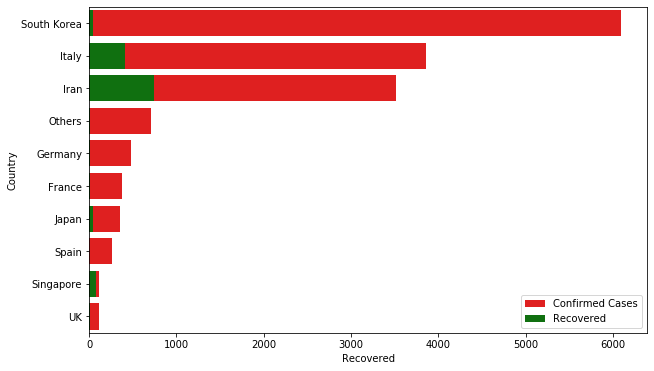

In [72]:
plt.figure(figsize=(10,6))
sns.barplot(x='Confirmed', y= 'Country', data = df_woc_top10, color='r', label='Confirmed Cases')
sns.barplot(x='Recovered', y= 'Country', data = df_woc_top10, color='g', label='Recovered')
plt.legend()
plt.show()